# Patient Classification


## Lab scoring system.

I will score all of the patients in the CLINTEK010 trial by how their lab results improved or degraded over time.

This is all based on the LBNRIND field in the LB domain.

* +1 means a lab improved into 'normal' range by the end of the study.
* 0 means the lab did not improve or get worse according to the normal range result.
* -1 means that the lab result got worse.

I produce a table of labs marked via this scoring system. 

Then I will assign a score to each patient by summing the score of all their lab results.

Assumption:

The higher this score, the more the patient improved over time.

Then I can use these scores to count the number of patients in each 'score' across the study.


In [1]:
import pandas as pd
import pyodbc
import sys
import numpy as np
import matplotlib.pyplot as plt
# the following connection string can be altered to point to different clinical trials as desired
conn = pyodbc.connect('DRIVER={SQL Server};Server=10.10.10.203;Database=sfls1_data;user=CDR_IIS_Account;password=eclinical.1;Trusted_Connection=false')

In [2]:
# this sql command grabs all of the labs in the study LB domain and performs the scoring as above. This is a work in progress
# I would suppress this, but Sam may be interested in reviewing the underlying query

sql = """
select 
    lb1.USUBJID, 
    lb1.LBSEQ, 
    lb1.LBCAT, 
    lb1.LBTEST, 
    lb1.LBORRES, 
    lb1.LBNRIND, 
    convert(datetime, lb1.LBDTC) LABDATE, lb1.LBBLFL,  
    ROW_NUMBER() over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC)) [rownum],
    FIRST_VALUE(lb1.LBNRIND) over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC) ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) [firstcondition],
    LAST_VALUE(lb1.LBNRIND) over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC) ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) [lastcondition],
    case 
        when LAST_VALUE(lb1.LBNRIND) over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC) ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) = 
        'NORMAL' then 
            case 
                when FIRST_VALUE(lb1.LBNRIND) over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC) ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) = 'NORMAL' then 0
            else
                1
            end
        else 
            case
                when LAST_VALUE(lb1.LBNRIND) over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC) ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) = 
                FIRST_VALUE(lb1.LBNRIND) over(partition by lb1.USUBJID,lb1.LBCAT,lb1.LBTEST order by convert(datetime, lb1.LBDTC) ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)  then 0
            else
                -1
            end
    end as score

FROM [sfls1_data].[Clintek_010].[LB] lb1 where lb1.LBSTAT is null and not lb1.[LBNRIND] is null 
and convert(datetime, lb1.LBDTC) >= 
(select top 1 convert(datetime, lb2.LBDTC) from [sfls1_data].[Clintek_010].[LB] lb2 where lb2.USUBJID = lb1.USUBJID and lb2.LBCAT = lb1.LBCAT and lb2.LBTEST = lb1.LBTEST and lb2.LBBLFL = 'Y')
"""
patientlabsscoringdf = pd.read_sql(sql, conn)

The following treatment produces a table that has one record for each lab.

Here is what this a few rows of this table look like:

In [3]:
# patientlabsscoringdf.head(10)
patientscore1df = patientlabsscoringdf[patientlabsscoringdf.LBBLFL.eq('Y')]
patientscore1df.head(10)

USUBJID  LBSEQ       LBCAT                            LBTEST  \
0   CLINTEK-010-0003-001     38   CHEMISTRY                           Amylase   
4   CLINTEK-010-0003-001    384   CHEMISTRY                            Sodium   
17  CLINTEK-010-0003-001    414   CHEMISTRY                             Urate   
19  CLINTEK-010-0003-001     65  HEMATOLOGY                         Basophils   
23  CLINTEK-010-0003-001    199  HEMATOLOGY                       Eosinophils   
27  CLINTEK-010-0003-001    204  HEMATOLOGY            Eosinophils/Leukocytes   
31  CLINTEK-010-0003-001    288  HEMATOLOGY  Ery. Mean Corpuscular Hemoglobin   
35  CLINTEK-010-0003-001    283  HEMATOLOGY            Lymphocytes/Leukocytes   
39  CLINTEK-010-0003-001    311  HEMATOLOGY                         Monocytes   
43  CLINTEK-010-0003-001    321  HEMATOLOGY                       Neutrophils   

   LBORRES LBNRIND    LABDATE LBBLFL  rownum firstcondition lastcondition  \
0       86  NORMAL 2018-02-26      Y       1         NORMAL          HIGH   
4      144  NORMAL 2018-02-26      Y       1         NORMAL          HIGH   
17     6.2  NORMAL 2018-02-26      Y       1         NORMAL          HIGH   
19     0.1  NORMAL 2018-02-26      Y       1         NORMAL        NORMAL   
23     0.1  NORMAL 2018-02-26      Y       1         NORMAL           LOW   
27     0.7     LOW 2018-02-26      Y       1            LOW           LOW   
31    32.5    HIGH 2018-02-26      Y       1           HIGH          HIGH   
35    15.6     LOW 2018-02-26      Y       1            LOW        NORMAL   
39     1.1    HIGH 2018-02-26      Y       1           HIGH        NORMAL   
43     6.9  NORMAL 2018-02-26      Y       1         NORMAL        NORMAL   

    score  
0      -1  
4      -1  
17     -1  
19      0  
23     -1  
27      0  
31      0  
35      1  
39      1  
43      0

The following shows the patient's group score (well, the first few records)

In [4]:
patientscore2df = patientscore1df.groupby(['USUBJID'])['score'].agg('sum')
patientscore2df.head(10)

USUBJID
CLINTEK-010-0003-001   -2
CLINTEK-010-0003-002   -9
CLINTEK-010-0003-003   -2
CLINTEK-010-0003-006   -9
CLINTEK-010-0003-007   -6
CLINTEK-010-0003-008    3
CLINTEK-010-0003-009   -2
CLINTEK-010-0005-001   -1
CLINTEK-010-0005-002   -1
CLINTEK-010-0005-003   -7
Name: score, dtype: int64

In [5]:
sql = 'select * from [Clintek_010].[DM]'
clintek10DMdf = pd.read_sql(sql, conn)

In [6]:
allsubjectsdf = clintek10DMdf[~clintek10DMdf.ARMCD.eq('SCRFAIL')]
subjFeaturesds = allsubjectsdf.drop(columns=['STUDYID','DOMAIN','SUBJID','ETHNIC','ACTARMCD','ACTARM', 'AGEU'])

After gathering patient features from the DM Domain, I merge these features into a table (technically a dataframe) that I can plot fatures against.

My First attempt is a scatter plot of score versus age

In [7]:
plotds = pd.merge(subjFeaturesds, patientscore2df, on='USUBJID', )
plot1df = plotds.replace(to_replace=['COHORT 1', 'COHORT 2'], value=[0,1])

In [8]:
fig1 = plt.figure( figsize=(10,10))
fig1.suptitle('Patient Labs Score versus Age -- All patients colored by ARM')
#plt.scatter(plot1df['AGE'], plot1df['score'], c=plot1df['ARM'])
ax1 = plt.gca()
ax1.set_ylabel('AGE')
ax1.set_xlabel('Summary Lab Score')
plt.scatter(plot1df['score'], plot1df['AGE'], c=plot1df['ARM'], s=50)

I was kind of expecting that younger patients would score better. The above graph does not seem to support this.

So below, I created a histogram structure that counts the number of patients in each score.

For example 28 patients scored a -4,  25 patients scored a 0 ... etc

Then I plotted these numbers and got the distribution of stats first for all patients, then broken out by COHORT

In [9]:
plot2df = plot1df.score.value_counts()
plot2df.head(10)

-4    28
 0    25
-2    25
-3    24
-1    24
-6    20
-7    19
-5    18
-8    15
 1    14
Name: score, dtype: int64

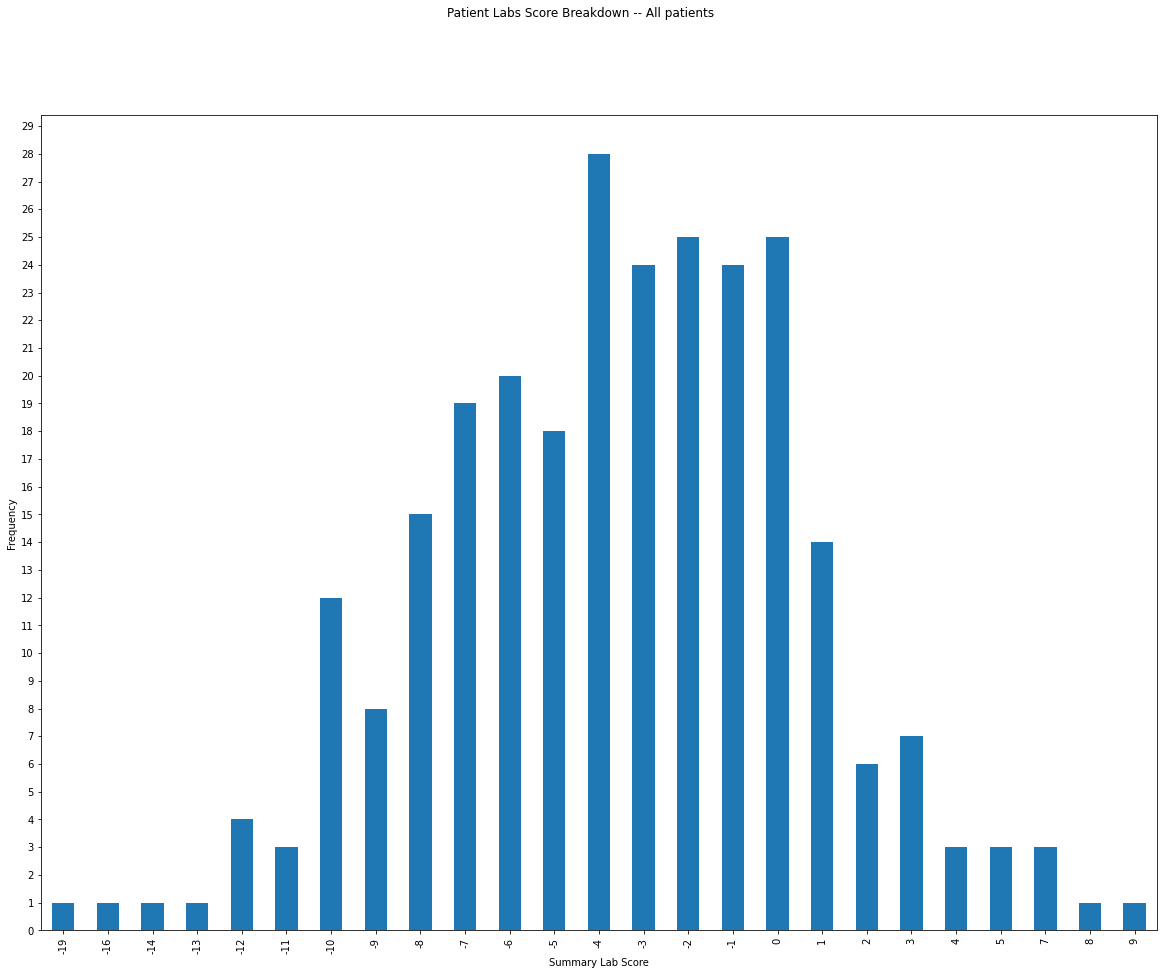

In [10]:
fig1 = plt.figure( figsize=(20,15))
fig1.suptitle('Patient Labs Score Breakdown -- All patients')
ax1 = plt.gca()
ax1.xaxis.set_ticks(np.arange(-21, 9, 1)) #odd in the offset
ax1.set_xlabel('Summary Lab Score')
ax1.yaxis.set_ticks(np.arange(0, 30, 1))
ax1.set_ylabel('Frequency')
plot1df['score'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [11]:
cohort1df = plot1df[plot1df.ARM.eq(0)]
cohort2df = plot1df[plot1df.ARM.eq(1)]

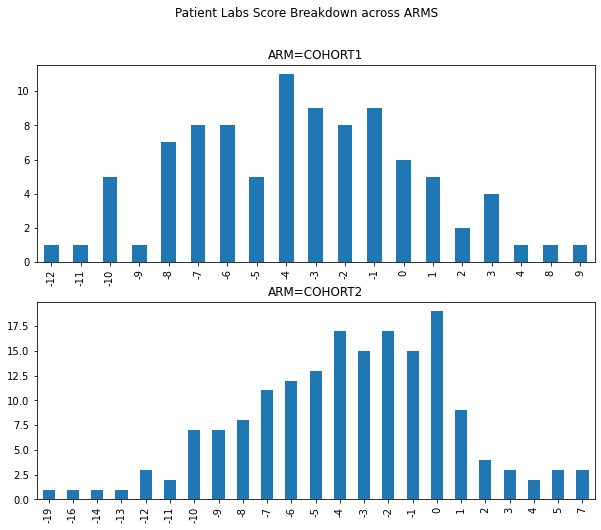

In [12]:
# fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# fig1.dpi = 100
fig1 = plt.figure( figsize=(10,8))
ax1 = fig1.add_subplot(2,1,1)
# ax2 = fig1.add_subplot(2,1,2,sharex=ax1, sharey=ax1)
ax2 = fig1.add_subplot(2,1,2)

fig1.suptitle('Patient Labs Score Breakdown across ARMS')
ax1.set_title('ARM=COHORT1')
ax2.set_title('ARM=COHORT2')

cohort1df['score'].value_counts().sort_index().plot(kind='bar', ax=ax1)
cohort2df['score'].value_counts().sort_index().plot(kind='bar', ax=ax2)
# try to set the same scale
# ax1.xaxis.set_ticks(np.arange(-20.0, 9.0, 1.0))
# ax2.xaxis.set_ticks(np.arange(-20.0, 9.0, 1.0))

# plt.tight_layout()

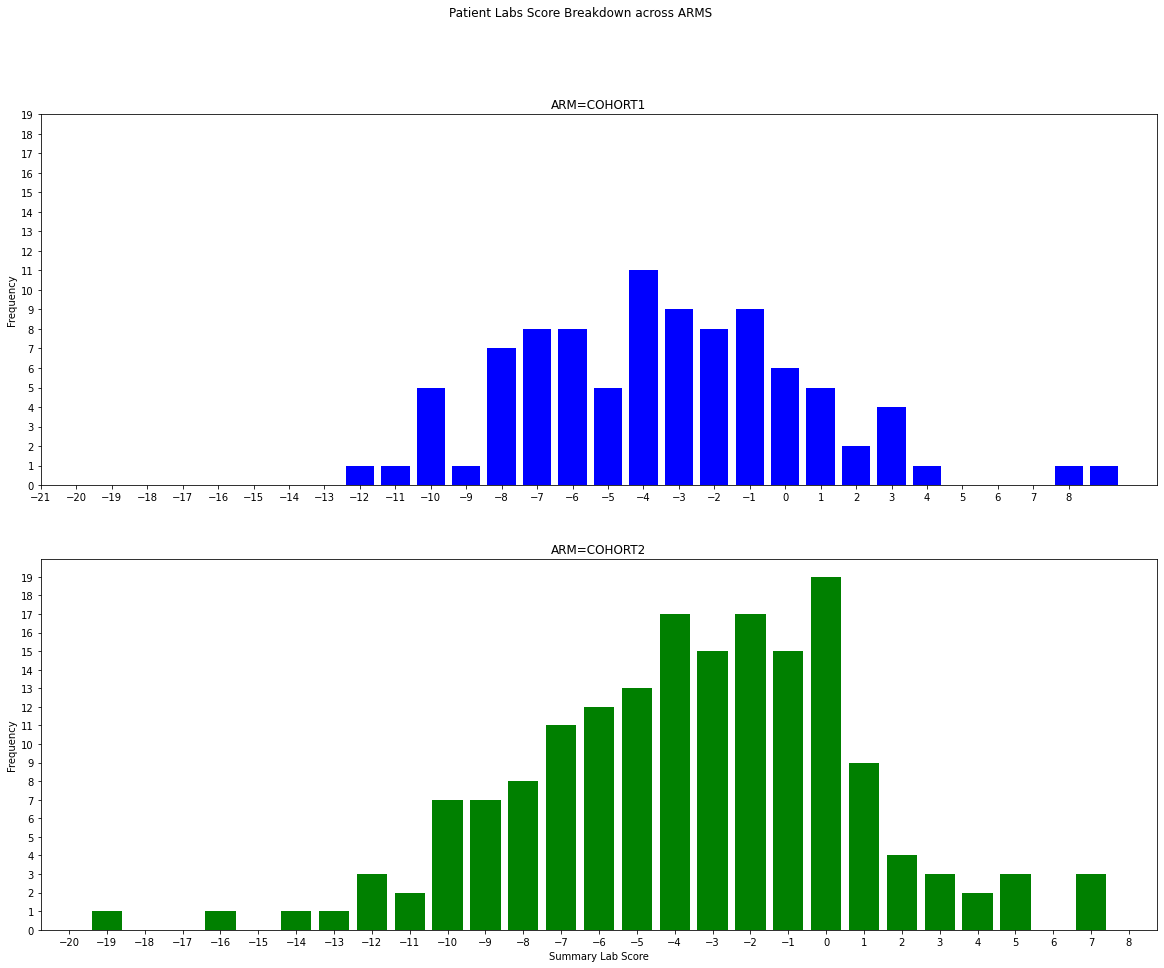

In [13]:
fig1 = plt.figure( figsize=(20,15))
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)

fig1.suptitle('Patient Labs Score Breakdown across ARMS')
ax1.set_title('ARM=COHORT1')
ax2.set_title('ARM=COHORT2')

xch1data = cohort1df['score'].value_counts().sort_index().index
ych1data = cohort1df['score'].value_counts().sort_index().values
ax1.bar(xch1data, ych1data, color='b')

xch2data = cohort2df['score'].value_counts().sort_index().index
ych2data = cohort2df['score'].value_counts().sort_index().values
ax2.bar(xch2data, ych2data, color='g')
# try to set the same scale
ax1.xaxis.set_ticks(np.arange(-21, 9, 1)) #odd in the offset
ax1.yaxis.set_ticks(np.arange(0, 20, 1))
ax1.set_ylabel('Frequency')
ax2.xaxis.set_ticks(np.arange(-20, 9, 1))
ax2.yaxis.set_ticks(np.arange(0, 20, 1))
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Summary Lab Score')

plt.show()

In [14]:
print('Overall study score stats')
print(plot1df.score.describe())
print('\nCOHORT 1 score stats')
print(cohort1df.score.describe())
print('\nCOHORT 2 score stats')
print(cohort2df.score.describe())

Overall study score stats
count    267.000000
mean      -3.535581
std        4.246366
min      -19.000000
25%       -6.000000
50%       -3.000000
75%       -1.000000
max        9.000000
Name: score, dtype: float64

COHORT 1 score stats
count    93.000000
mean     -3.451613
std       4.036562
min     -12.000000
25%      -6.000000
50%      -4.000000
75%      -1.000000
max       9.000000
Name: score, dtype: float64

COHORT 2 score stats
count    174.00000
mean      -3.58046
std        4.36511
min      -19.00000
25%       -6.00000
50%       -3.00000
75%       -1.00000
max        7.00000
Name: score, dtype: float64


## Conclusions Thus Far:
# It would appear for this study there was very little statistical advantage to be in either COHORT 1 or COHORT 2

The mean Lab Score in COHORT 1 was -3.45

The mean Lab Score in COHORT 2 was -3.58

The mean Lab Score study wide was -3.53

# I am not a Medical Examiner, I just have a keyboard and a graphing package BUT

## If one of these ARMS were placebo I would say that either these treatments were ineffective OR my scoring system is ineffective.

I should check with Sam and Rob before going much farther.

If the scoring system seems valid, some next steps would be:

- Compare scores to Concurrent Meds to test for a correlation.
- Compare scores to Medical history, or Adverse Events, or anything to find any correlation.


## please ignore everything from this point down as I will be trying to come up with a generic way to compare features by patient score

I should delete this kruft before presenting, butsometimes presenting happens

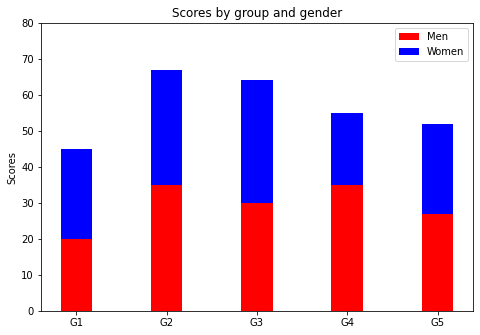

In [15]:
# just proctice with graphing stacked bar graphs for a while
#import numpy as np# thought I had this already
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
totalMeans = tuple(map(sum,zip(menMeans,womenMeans)))
nonWomansMeans = tuple(np.subtract(totalMeans, womenMeans))
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#ax.bar(ind, menMeans, width, color='r')
ax.bar(ind, nonWomansMeans, width, color='r')
ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
# ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.xticks(ind, ['G1', 'G2', 'G3', 'G4', 'G5'])
ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Men', 'Women'])
plt.show()

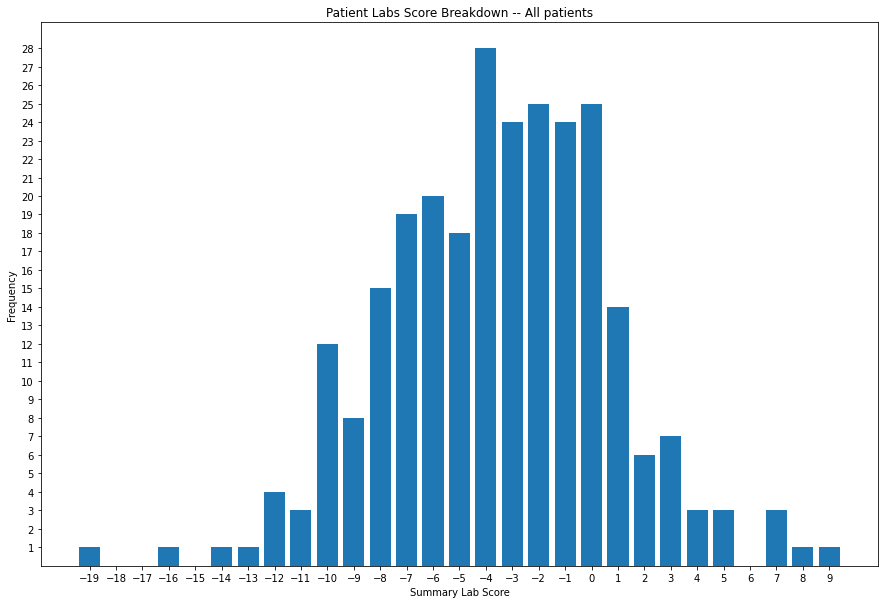

(-19, -16, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 8, 9)
(1, 1, 1, 1, 4, 3, 12, 8, 15, 19, 20, 18, 28, 24, 25, 24, 25, 14, 6, 7, 3, 3, 3, 1, 1)


In [16]:
# with the above knowledge gained, apply this bar chart to our big old dataframe
fig1 = plt.figure( figsize=(15,10))
#fig1.suptitle('Patient Labs Score Breakdown -- All patients')
ax1 = plt.gca()
ax1.set(Title='Patient Labs Score Breakdown -- All patients', xlabel='Summary Lab Score', ylabel='Frequency')
vcs = plot1df['score'].value_counts()
ax1.xaxis.set_ticks(np.arange(min(vcs.index), max(vcs.index) + 1, 1)) #odd in the offset
ax1.yaxis.set_ticks(np.arange(min(vcs), max(vcs) + 1, 1)) #odd in the offset
#ax1.xaxis.set_ticks(np.arange(-21, 9, 1)) #odd in the offset
#ax1.set_xlabel('Summary Lab Score')
#ax1.yaxis.set_ticks(np.arange(0, 30, 1))
#ax1.set_ylabel('Frequency')
#plot1df['score'].value_counts().sort_index().plot(kind='bar')
#vcs.sort_index().plot(kind='bar', ax=ax1)
x = tuple(vcs.sort_index().index)
y = tuple(vcs.sort_index())
ax1.bar(x, y)
plt.show()

# print(vcs.sort_index().index)
# print(vcs.sort_index().values)
print(x)
print(y)

In [17]:
fig1 = plt.figure( figsize=(15,10))
ax1 = plt.gca()
ax1.set(Title='Patient Labs Score Breakdown -- All patients', xlabel='Summary Lab Score', ylabel='Frequency')
vcs = plot1df['score'].value_counts()
xrange = np.arange(min(vcs.index), max(vcs.index) + 1, 1)
ax1.xaxis.set_ticks(xrange) #odd in the offset
ax1.yaxis.set_ticks(np.arange(min(vcs), max(vcs) + 1, 1)) #odd in the offset
width = 0.35

a = []
b = []
ch1df = plot1df[plot1df.ARM == 0]
ch2df = plot1df[plot1df.ARM == 1]


for i in xrange:
    a.append(ch1df[ch1df.score == i]['score'].count())
    b.append(ch2df[ch2df.score == i]['score'].count())
    
a = tuple(a)
b=tuple(b)

x1 = tuple(ch1df['score'].value_counts().sort_index().index)
y1 = tuple(ch1df['score'].value_counts().sort_index())
# print(x1)
# print(y1)
# ax1.bar(x1, y1, width, color='r')
ax1.bar(xrange, a, width, color='r')
#ax1.bar(ch1df.sort_index().index, ch1df.sort_index(), width, color='r')
x2 = tuple(ch2df['score'].value_counts().sort_index().index)
y2 = tuple(ch2df['score'].value_counts().sort_index())
# ax1.bar(x2, y2, width, bottom=x1, color='b')
#ax1.bar(x2, y2, width, color='b')
ax1.bar(xrange, b, width, bottom=a, color='b')


plt.show()
print(a)
print(b)

(0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 1, 7, 8, 8, 5, 11, 9, 8, 9, 6, 5, 2, 4, 1, 0, 0, 0, 1, 1)
(1, 0, 0, 1, 0, 1, 1, 3, 2, 7, 7, 8, 11, 12, 13, 17, 15, 17, 15, 19, 9, 4, 3, 2, 3, 0, 3, 0, 0)


In [18]:
sql = """select USUBJID, CMDECOD from [sfls1_data].[Clintek_010].[CM]
where CMENRF = 'ONGOING'
group by USUBJID, CMDECOD
"""
ongoingcomedsdf = pd.read_sql(sql, conn)

In [19]:
ongoingcomedsdf.head(5)

USUBJID                    CMDECOD
0  CLINTEK-010-0003-002     ATROPINE;DIPHENOXYLATE
1  CLINTEK-010-0003-002                 CARVEDILOL
2  CLINTEK-010-0003-002                  CELECOXIB
3  CLINTEK-010-0003-002                 GABAPENTIN
4  CLINTEK-010-0003-002  LACTOBACILLUS ACIDOPHILUS

In [20]:
uniquecomeds = ongoingcomedsdf.CMDECOD.unique()

In [21]:
plot1df.head(5)

USUBJID     RFSTDTC     RFENDTC    RFXSTDTC    RFXENDTC  \
0  CLINTEK-010-0473-009  2016-10-26  2019-10-07  2016-10-26  2019-07-17   
1  CLINTEK-010-0473-003  2017-02-08  2017-03-23  2017-02-08  2017-03-05   
2  CLINTEK-010-0473-001  2017-10-24  2020-02-06  2017-10-24  2019-04-24   
3  CLINTEK-010-0473-005  2018-02-22  2018-05-08  2018-02-22  2018-03-19   
4  CLINTEK-010-0473-004  2018-05-30  2019-04-16  2018-05-30  2018-12-19   

      RFICDTC    RFPENDTC      DTHDTC DTHFL SITEID     BRTHDTC  AGE SEX  \
0  2016-10-17  2019-10-07        None  None  00473  1964-05-18   52   F   
1  2017-01-30  2017-03-23  2017-03-23     Y  00473  1945-10-20   72   M   
2  2017-10-03  2020-02-06        None  None  00473  1931-10-16   86   F   
3  2018-02-06  2018-05-08  2018-05-08     Y  00473  1950-03-15   68   M   
4  2018-05-08  2019-04-16        None  None  00473  1966-05-31   52   M   

    RACE  ARMCD  ARM COUNTRY  score  
0  WHITE      0    0     ESP     -8  
1  WHITE      1    1     ESP      2  
2  WHITE      1    1     ESP     -5  
3  WHITE      1    1     ESP     -3  
4  WHITE      1    1     ESP     -4

In [22]:
averagescore = -4
goodthreashold = plot1df[plot1df.score > averagescore]['score'].count()
badthreashold = plot1df[plot1df.score < averagescore]['score'].count()
data = []
for comed in uniquecomeds:
    singlecomeddf = ongoingcomedsdf[ongoingcomedsdf.CMDECOD.eq(comed)]
    testdf = pd.merge(plot1df, singlecomeddf, on='USUBJID')
    compareval = testdf[testdf.score > averagescore]['score'].count()
    badcompareval = testdf[testdf.score < averagescore]['score'].count()
    if(compareval/goodthreashold > 0.5):
        print( comed + ' is used by alot pf patients with imporved scores')
    if(compareval/badthreashold > 0.5):
        print( comed + ' is used by alot pf patients with degraded scores')
    data.append((comed, compareval, compareval/goodthreashold, badcompareval, badcompareval/badthreashold))
comedscoresdf = pd.DataFrame(data, columns = ['COMED','USEDBYIMPROVEDVALUE','USEDBYIMPROVEDPCT','USEDBYDEGRADEDVALUE','USEDBYDEGRADEDPCT'])
    

ONDANSETRON is used by alot pf patients with imporved scores
ONDANSETRON is used by alot pf patients with degraded scores


In [23]:
# comedscoresdf.head(10)
comedscoresdf.sort_values('USEDBYDEGRADEDVALUE', ascending=0).head(10)

COMED  USEDBYIMPROVEDVALUE  USEDBYIMPROVEDPCT  \
8                      ONDANSETRON                   77           0.566176   
31                     PARACETAMOL                   29           0.213235   
7                       OMEPRAZOLE                   27           0.198529   
93   SULFAMETHOXAZOLE;TRIMETHOPRIM                   18           0.132353   
22                       ACICLOVIR                   26           0.191176   
48                     ALLOPURINOL                   25           0.183824   
119                   PANTOPRAZOLE                   13           0.095588   
56                      FUROSEMIDE                   14           0.102941   
11            ACETYLSALICYLIC ACID                   16           0.117647   
19      VALACICLOVIR HYDROCHLORIDE                   14           0.102941   

     USEDBYDEGRADEDVALUE  USEDBYDEGRADEDPCT  
8                     58           0.563107  
31                    26           0.252427  
7                     21           0.203883  
93                    20           0.194175  
22                    20           0.194175  
48                    19           0.184466  
119                   16           0.155340  
56                    12           0.116505  
11                    11           0.106796  
19                    10           0.097087

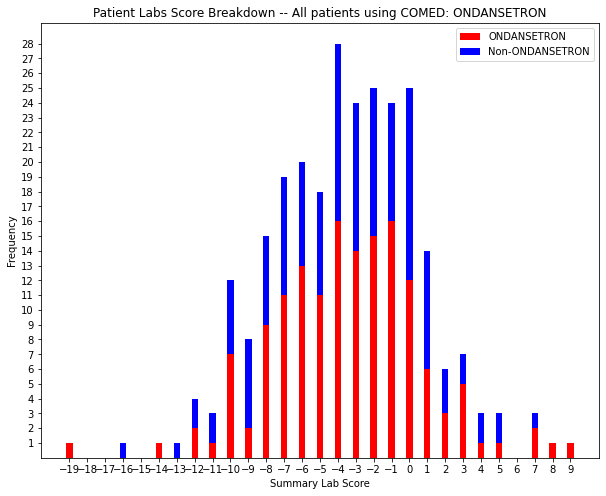

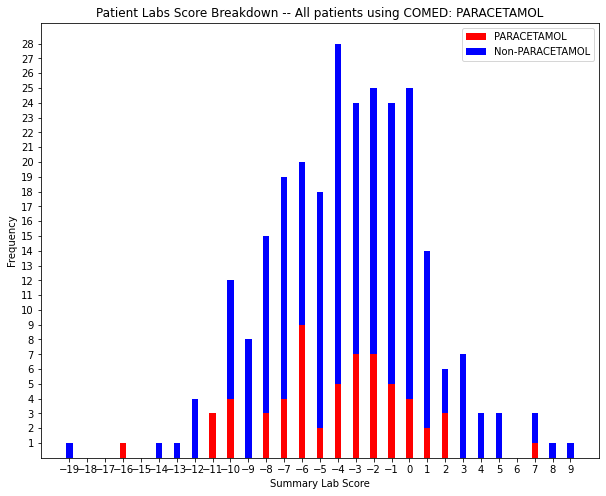

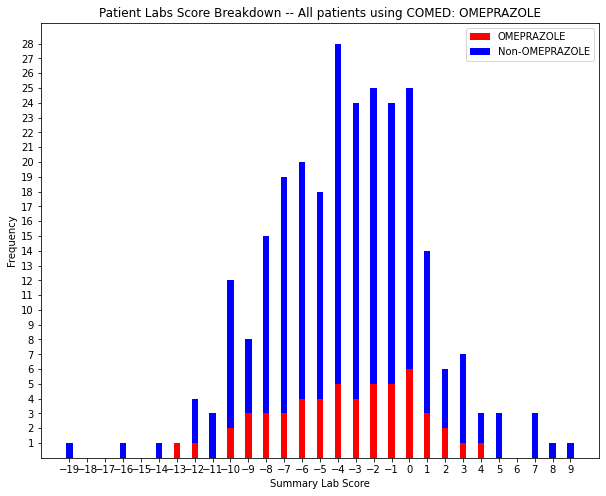

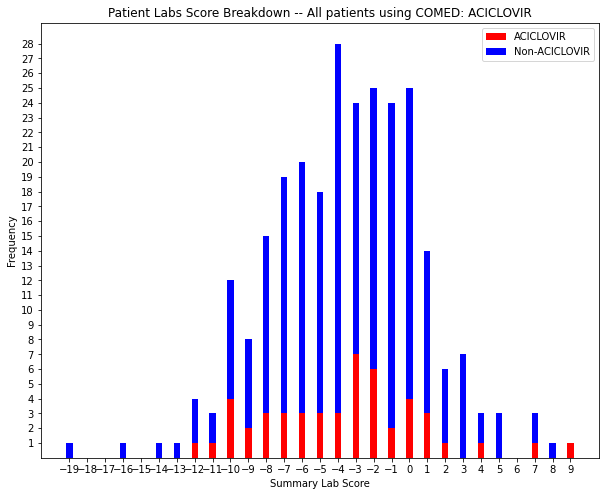

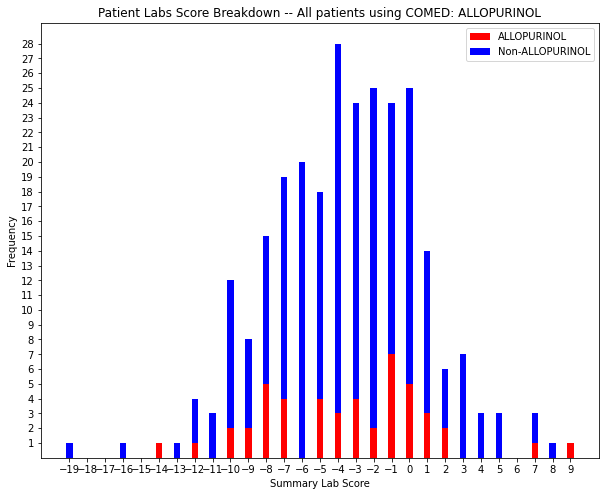

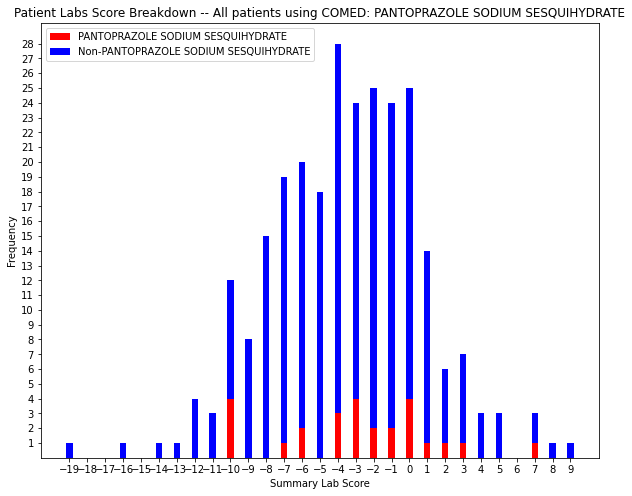

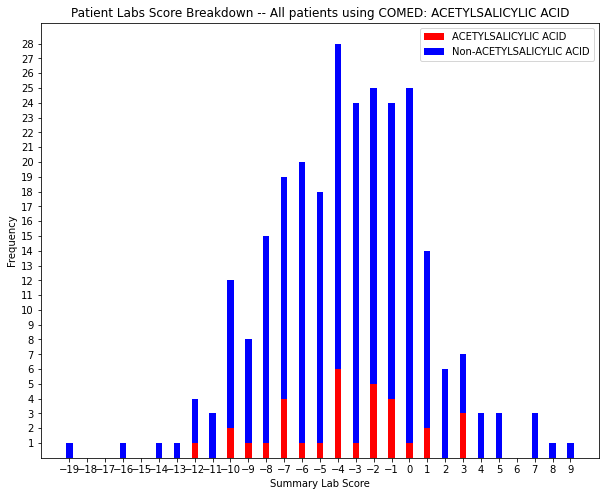

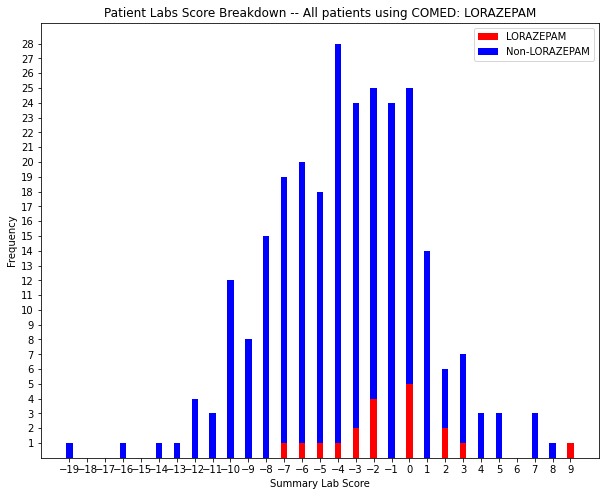

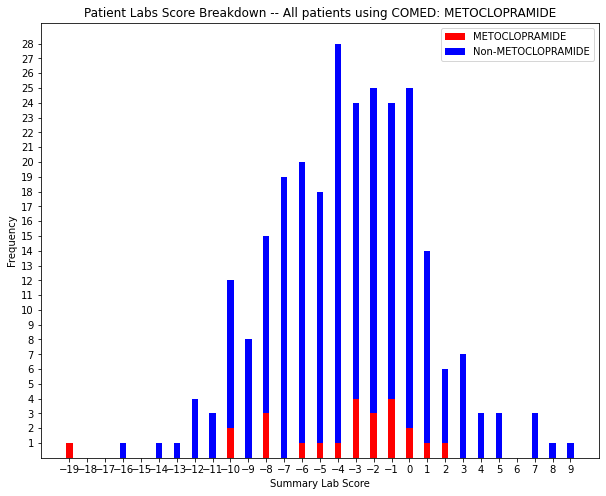

In [27]:
for index, row in comedscoresdf.sort_values('USEDBYIMPROVEDVALUE', ascending=0).head(10).iterrows():
    plotcomeddistrib(plot1df, ongoingcomedsdf, row['COMED'])

In [26]:
def plotcomeddistrib( xplotdf, xcomeddf,  comed):
    fig1 = plt.figure( figsize=(10,8))
    ax1 = plt.gca()
    
    ax1.set(Title=f'Patient Labs Score Breakdown -- All patients using COMED: {comed}', xlabel='Summary Lab Score', ylabel='Frequency')
    vcs = xplotdf['score'].value_counts()
    xrange = np.arange(min(vcs.index), max(vcs.index) + 1, 1)
    ax1.xaxis.set_ticks(xrange) #odd in the offset
    ax1.yaxis.set_ticks(np.arange(min(vcs), max(vcs) + 1, 1)) #odd in the offset
    width = 0.35

    singlecomeddf = ongoingcomedsdf[ongoingcomedsdf.CMDECOD.eq(comed)]
    testdf = pd.merge(xplotdf, singlecomeddf, on='USUBJID', how='left')
    a = []
    b = []
    ch1df = testdf[testdf['CMDECOD'] == comed]
    ch2df = testdf[testdf['CMDECOD'] != comed]


    for i in xrange:
        a.append(ch1df[ch1df.score == i]['score'].count())
        b.append(ch2df[ch2df.score == i]['score'].count())

    a = tuple(a)
    b=tuple(b)

    x1 = tuple(ch1df['score'].value_counts().sort_index().index)
    y1 = tuple(ch1df['score'].value_counts().sort_index())
    ax1.bar(xrange, a, width, color='r')
    x2 = tuple(ch2df['score'].value_counts().sort_index().index)
    y2 = tuple(ch2df['score'].value_counts().sort_index())
    ax1.bar(xrange, b, width, bottom=a, color='b')
    ax1.legend(labels=[comed, f'Non-{comed}'])

    plt.show()
#     print(a)
#     print(b)

In [28]:
# for some thing different
# what are the most common commeds for patients that have success scores > N ? For scores < M?
# plot1df, ongoingcomedsdf
muchImprovedPatients = plot1df[plot1df.score > 2]
# there are 18 patients out of ~250 with a score of 3 or better, so what do they take for comeds
#muchImprovedPatients.describe()

result = pd.merge(muchImprovedPatients, ongoingcomedsdf, how='left')
result.drop(columns=['RFSTDTC','RFENDTC','RFXSTDTC', 'RFXENDTC', 'RFICDTC', 'RFPENDTC'], inplace=True)
result.CMDECOD.value_counts().head(10)

ONDANSETRON                      11
SULFAMETHOXAZOLE;TRIMETHOPRIM     4
FLUCONAZOLE                       3
LOPERAMIDE                        3
PANTOPRAZOLE                      3
ACICLOVIR                         3
ACETYLSALICYLIC ACID              3
LEVOTHYROXINE SODIUM              3
VALACICLOVIR HYDROCHLORIDE        3
ATORVASTATIN CALCIUM              3
Name: CMDECOD, dtype: int64

## Problem:

### A certain study found an Adverse reaction when patients over the age of 65 were exposed using a CONMED blood thinner

### How to find this

In [29]:
sql = "select * from [sfls1_data].[Clintek_010].[AE]"
aedf = pd.read_sql(sql, conn)

In [30]:
saedf = aedf[aedf.AESER == 'Y']
#saedf['AETERM'].value_counts()

smalleraedf = aedf[["USUBJID", "AETERM", "AELLT","AEDECOD", "AESER", "AEACN", "AEREL", "EPOCH", "AEENRF"]]
uniquesmalleraedf = smalleraedf.drop_duplicates(["USUBJID", "AETERM"])
uniquesmalleraedf["AETERM"].value_counts()

NAUSEA                                      133
FATIGUE                                     108
ANEMIA                                       90
THROMBOCYTOPENIA                             80
WEIGHT LOSS                                  76
                                           ... 
WEIGHT LOSS ( SYMPTOME DUE TO ANOREXIA )      1
OCCASIONAL ASTENIA                            1
WBC  DECREASED                                1
ANEMIA WORSENING                              1
WORSENING ABDOMEN PAIN                        1
Name: AETERM, Length: 1314, dtype: int64

In [31]:
testdf = pd.merge(subjFeaturesds, uniquesmalleraedf[uniquesmalleraedf["AETERM"] == 'NAUSEA'][["USUBJID","AETERM"]], on='USUBJID', how="left")
testdf.head(5)

USUBJID     RFSTDTC     RFENDTC    RFXSTDTC    RFXENDTC  \
0  CLINTEK-010-0473-009  2016-10-26  2019-10-07  2016-10-26  2019-07-17   
1  CLINTEK-010-0473-003  2017-02-08  2017-03-23  2017-02-08  2017-03-05   
2  CLINTEK-010-0473-001  2017-10-24  2020-02-06  2017-10-24  2019-04-24   
3  CLINTEK-010-0473-005  2018-02-22  2018-05-08  2018-02-22  2018-03-19   
4  CLINTEK-010-0473-004  2018-05-30  2019-04-16  2018-05-30  2018-12-19   

      RFICDTC    RFPENDTC      DTHDTC DTHFL SITEID     BRTHDTC  AGE SEX  \
0  2016-10-17  2019-10-07        None  None  00473  1964-05-18   52   F   
1  2017-01-30  2017-03-23  2017-03-23     Y  00473  1945-10-20   72   M   
2  2017-10-03  2020-02-06        None  None  00473  1931-10-16   86   F   
3  2018-02-06  2018-05-08  2018-05-08     Y  00473  1950-03-15   68   M   
4  2018-05-08  2019-04-16        None  None  00473  1966-05-31   52   M   

    RACE     ARMCD       ARM COUNTRY AETERM  
0  WHITE  COHORT 1  COHORT 1     ESP    NaN  
1  WHITE  COHORT 2  COHORT 2     ESP    NaN  
2  WHITE  COHORT 2  COHORT 2     ESP    NaN  
3  WHITE  COHORT 2  COHORT 2     ESP    NaN  
4  WHITE  COHORT 2  COHORT 2     ESP    NaN

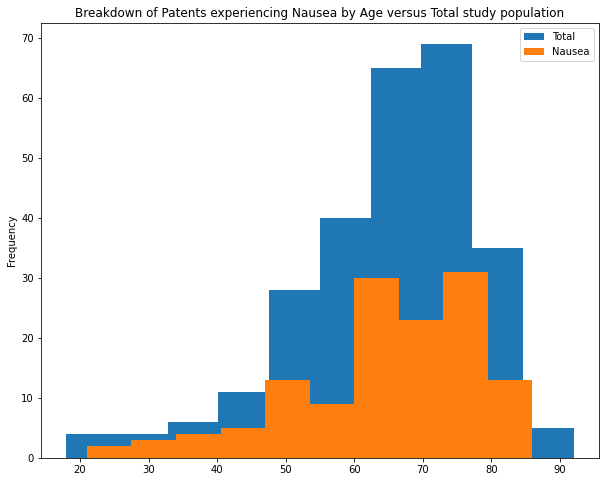

In [32]:
fig1 = plt.figure( figsize=(10,8))
ax1 = plt.gca()

ax1.set(Title=f'Breakdown of Patents experiencing Nausea by Age versus Total study population')
testdf.AGE.plot(kind='hist')
testdf[testdf.AETERM.eq("NAUSEA")].AGE.plot(kind='hist')
ax1.legend(labels=["Total", "Nausea"])


## That worked out ok. Now for a function that can visualize any of the top 5 AEs

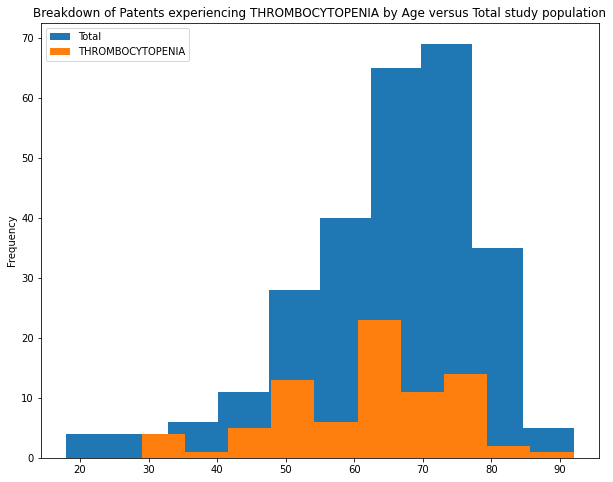

In [33]:
testdf = pd.merge(subjFeaturesds, uniquesmalleraedf[uniquesmalleraedf["AETERM"] == 'THROMBOCYTOPENIA'][["USUBJID","AETERM"]], on='USUBJID', how="left")
fig1 = plt.figure( figsize=(10,8))
ax1 = plt.gca()

ax1.set(Title=f'Breakdown of Patents experiencing THROMBOCYTOPENIA by Age versus Total study population')
testdf.AGE.plot(kind='hist')
testdf[testdf.AETERM.eq("THROMBOCYTOPENIA")].AGE.plot(kind='hist')
ax1.legend(labels=["Total", "THROMBOCYTOPENIA"])

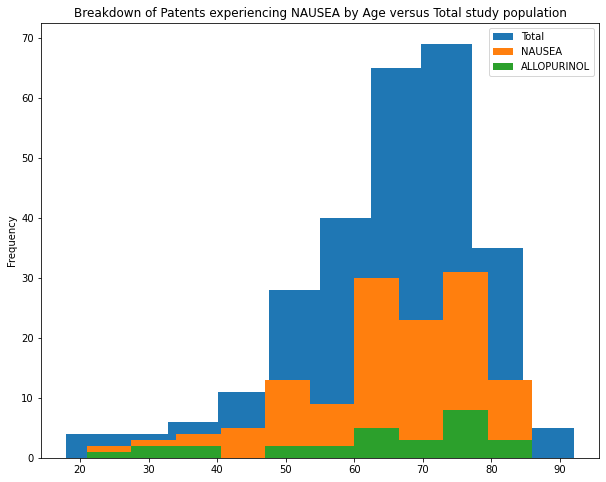

In [34]:
testdf = pd.merge(subjFeaturesds, uniquesmalleraedf[uniquesmalleraedf["AETERM"] == 'NAUSEA'][["USUBJID","AETERM"]], on='USUBJID', how="left")
testdf = pd.merge(testdf, ongoingcomedsdf[ongoingcomedsdf['CMDECOD'] == 'ALLOPURINOL'], on='USUBJID', how="left" )
fig1 = plt.figure( figsize=(10,8))
ax1 = plt.gca()

ax1.set(Title=f'Breakdown of Patents experiencing NAUSEA by Age versus Total study population')
testdf.AGE.plot(kind='hist')
ae_filter = testdf.AETERM.eq("NAUSEA")
testdf[ae_filter].AGE.plot(kind='hist')
conmed_filter = testdf.CMDECOD.eq("ALLOPURINOL")
testdf[ae_filter & conmed_filter].AGE.plot(kind='hist')
ax1.legend(labels=["Total", "NAUSEA", "ALLOPURINOL"])

## The following is a brief experiment with tensorflow  that may or may not prove useful

In [ ]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
#there are some columns in the dataframe that cause tensorflow problems, right now I will drop them
testtensorflowds = plotds.drop(columns=['DTHDTC', 'COUNTRY', 'DTHFL', 'RACE']) # find out why it has a problem with COUNTRY and RACE

train, test = train_test_split(testtensorflowds, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('score')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of AGES:', feature_batch['AGE'])

In [ ]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [ ]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [ ]:
age = feature_column.numeric_column("AGE")
demo(age)

In [ ]:
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

## ultimately it would come down to training and creating a model based on a set of features that could be trained and rated as below

In [ ]:
# this model is not ready to be created and run as the feature set is neither complete or properly formatted
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

# the model could be evaluated as follows
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)